<a href="https://colab.research.google.com/github/kinshu0/piecewise-drug-nn/blob/main/piecewise_drug_data_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.tree_util import Partial
import optax
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
key = jax.random.PRNGKey(0)

# Piecewise function for drug effect
def drug_piecewise(x):
    low_effect = jnp.where(x < 1.0, 0.1, 0.0)
    medium_low_effect = jnp.where((x >= 1.0) & (x <= 2.0), 0.8 * x - 0.7, 0.0)
    medium_high_effect = jnp.where((x >= 2.0) & (x <= 3.0), -0.8 * x + 2.5, 0.0)
    high_effect = jnp.where(x > 3.0, 0.1, 0.0)
    effect = low_effect + medium_low_effect + medium_high_effect + high_effect
    return effect

# Generate synthetic data
n_datapoints = 1280
key, x_key, noise_key = jax.random.split(key, 3)

x = jax.random.uniform(x_key, minval=0, maxval=4, shape=(n_datapoints,))
perfect_y = drug_piecewise(x)
noise_scaling = 0.02
noise = jax.random.normal(noise_key, shape=(n_datapoints,))
scaled_noise = noise * noise_scaling
y = perfect_y + scaled_noise

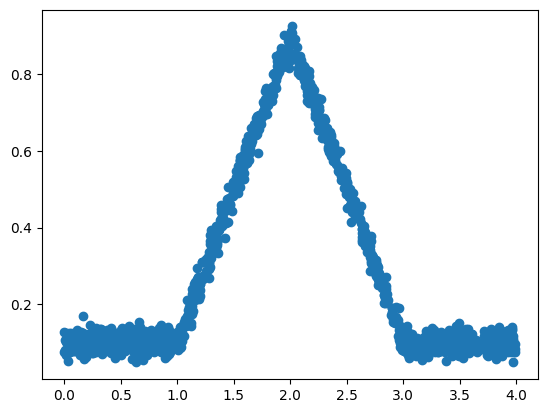

In [ ]:
plt.scatter(x, y)

In [ ]:
drug_data = jnp.stack([x, y], axis=1)
drug_data_split_idx = int(len(drug_data) * 0.8)
train_drug_data, test_drug_data = drug_data[:drug_data_split_idx], drug_data[drug_data_split_idx:]

# Normalize data
mean = jnp.mean(train_drug_data, axis=0)
std = jnp.std(train_drug_data, axis=0)
normalized_train_data = (train_drug_data - mean) / std
normalized_test_data = (test_drug_data - mean) / std

In [ ]:
# Define neural network
def init_network_params(layer_sizes, key):
    keys = jax.random.split(key, len(layer_sizes))
    return [
        {'w': jax.random.normal(k, (m, n)) * jnp.sqrt(2.0 / m),
         'b': jax.random.normal(k, (n,)) * 0.01}
        for k, m, n in zip(keys, layer_sizes[:-1], layer_sizes[1:])
    ]

def network_forward(params, inputs):
    activations = inputs
    for layer in params[:-1]:
        activations = jax.nn.relu(jnp.dot(activations, layer['w']) + layer['b'])
    final_layer = params[-1]
    return jnp.dot(activations, final_layer['w']) + final_layer['b']

def network_forward_without_activation(params, inputs):
    activations = inputs
    for layer in params[:-1]:
        activations = jnp.dot(activations, layer['w']) + layer['b']
    final_layer = params[-1]
    return jnp.dot(activations, final_layer['w']) + final_layer['b']

# Parameterized loss function
def create_loss_fn(forward_fn):
    def loss(params, inputs, targets):
        predictions = forward_fn(params, inputs)
        return jnp.mean((predictions - targets) ** 2)
    return loss

# Parameterized update function
def create_update_fn(forward_fn, optimizer):
    loss_fn = create_loss_fn(forward_fn)

    @jax.jit
    def update(params, inputs, targets, opt_state):
        loss_value, grads = jax.value_and_grad(loss_fn)(params, inputs, targets)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    return update

In [ ]:
# Parameterized training function
def train_model(forward_fn, normalized_train_data_x, normalized_train_data_y, layer_sizes, learning_rate, n_epochs, batch_size):
    params = init_network_params(layer_sizes, jax.random.PRNGKey(1))
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)

    update_fn = create_update_fn(forward_fn, optimizer)

    train_losses = []

    for epoch in range(n_epochs):
        perm = jax.random.permutation(jax.random.PRNGKey(epoch), len(normalized_train_data_x))
        shuffled_x = normalized_train_data_x[perm]
        shuffled_y = normalized_train_data_y[perm]

        for i in range(0, len(normalized_train_data_x), batch_size):
            batch_x = shuffled_x[i:i+batch_size]
            batch_y = shuffled_y[i:i+batch_size]
            params, opt_state, train_loss = update_fn(params, batch_x, batch_y, opt_state)

        if epoch % 100 == 0:
            train_losses.append(train_loss)
            print(f"Epoch {epoch}, Train Loss: {train_loss}")

    return params, train_losses

In [ ]:
# Training and evaluation
normalized_train_data_x = normalized_train_data[:, 0].reshape(-1, 1)
normalized_train_data_y = normalized_train_data[:, 1].reshape(-1, 1)

layer_sizes = [1, 256, 256, 256, 256, 1]
learning_rate = 0.001
n_epochs = 2000
batch_size = 32

# Train linear model
linear_params, linear_losses = train_model(network_forward_without_activation, normalized_train_data_x, normalized_train_data_y,
                                           layer_sizes, learning_rate, n_epochs, batch_size)

# Train non-linear model
nonlinear_params, nonlinear_losses = train_model(network_forward, normalized_train_data_x, normalized_train_data_y,
                                                 layer_sizes, learning_rate, n_epochs, batch_size)

Epoch 0, Train Loss: 1.3162120580673218
Epoch 100, Train Loss: 1.1471431255340576
Epoch 200, Train Loss: 0.8724062442779541
Epoch 300, Train Loss: 1.2489193677902222
Epoch 400, Train Loss: 0.7847751379013062
Epoch 500, Train Loss: 1.3514124155044556
Epoch 600, Train Loss: 1.4837455749511719
Epoch 700, Train Loss: 0.7807025909423828
Epoch 800, Train Loss: 1.1420607566833496
Epoch 900, Train Loss: 1.5727651119232178
Epoch 1000, Train Loss: 0.7041921019554138
Epoch 1100, Train Loss: 1.1464335918426514
Epoch 1200, Train Loss: 0.6777092218399048
Epoch 1300, Train Loss: 1.1143972873687744
Epoch 1400, Train Loss: 1.2670680284500122
Epoch 1500, Train Loss: 1.285940170288086
Epoch 1600, Train Loss: 1.2231332063674927
Epoch 1700, Train Loss: 1.260764718055725
Epoch 1800, Train Loss: 0.9182615280151367
Epoch 1900, Train Loss: 1.2512180805206299
Epoch 0, Train Loss: 0.8797039985656738
Epoch 100, Train Loss: 0.008090602234005928
Epoch 200, Train Loss: 0.006341542117297649
Epoch 300, Train Loss: 0.0

In [ ]:
# Parameterized prediction function
def create_predict_fn(forward_fn):
    @jax.jit
    def predict(params, inputs):
        return forward_fn(params, inputs)
    return predict

In [ ]:
# Create prediction functions
linear_predict = create_predict_fn(network_forward_without_activation)
nonlinear_predict = create_predict_fn(network_forward)

# Evaluate models
linear_train_predictions = linear_predict(linear_params, normalized_train_data[:, 0].reshape(-1, 1))
linear_test_predictions = linear_predict(linear_params, normalized_test_data[:, 0].reshape(-1, 1))

nonlinear_train_predictions = nonlinear_predict(nonlinear_params, normalized_train_data[:, 0].reshape(-1, 1))
nonlinear_test_predictions = nonlinear_predict(nonlinear_params, normalized_test_data[:, 0].reshape(-1, 1))

# Denormalize predictions
linear_train_predictions = linear_train_predictions * std[1] + mean[1]
linear_test_predictions = linear_test_predictions * std[1] + mean[1]
nonlinear_train_predictions = nonlinear_train_predictions * std[1] + mean[1]
nonlinear_test_predictions = nonlinear_test_predictions * std[1] + mean[1]

Text(0, 0.5, 'Effect')

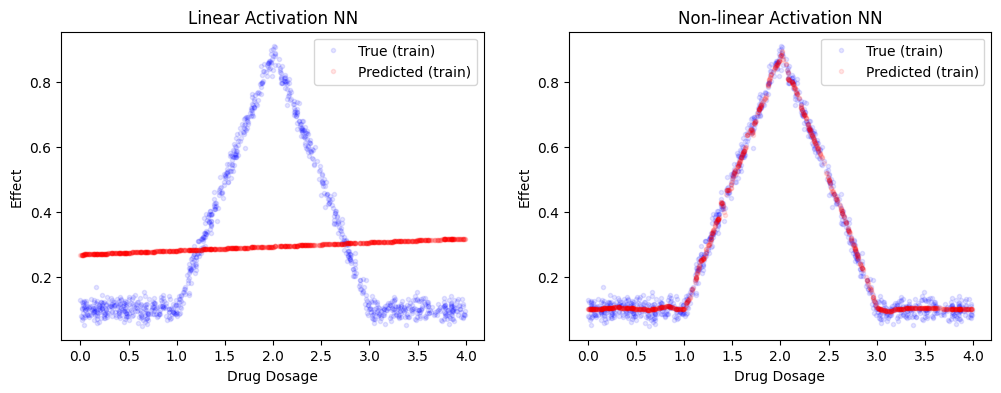

In [ ]:
plt.figure(figsize=(12, 4))

# Plot results
plt.subplot(121)
plt.plot(train_drug_data[:, 0], train_drug_data[:, 1], 'b.', alpha=0.1, label='True (train)')
plt.plot(train_drug_data[:, 0], linear_train_predictions, 'r.', alpha=0.1, label='Predicted (train)')
plt.legend()
plt.title('Linear Activation NN Train')
plt.xlabel('Drug Dosage')
plt.ylabel('Effect')

# Plot for Non-linear Model
plt.subplot(122)
plt.plot(train_drug_data[:, 0], train_drug_data[:, 1], 'b.', alpha=0.1, label='True (train)')
plt.plot(train_drug_data[:, 0], nonlinear_train_predictions, 'r.', alpha=0.1, label='Predicted (train)')
plt.legend()
plt.title('Non-linear Activation NN Train')
plt.xlabel('Drug Dosage')
plt.ylabel('Effect')

Text(0, 0.5, 'Effect')

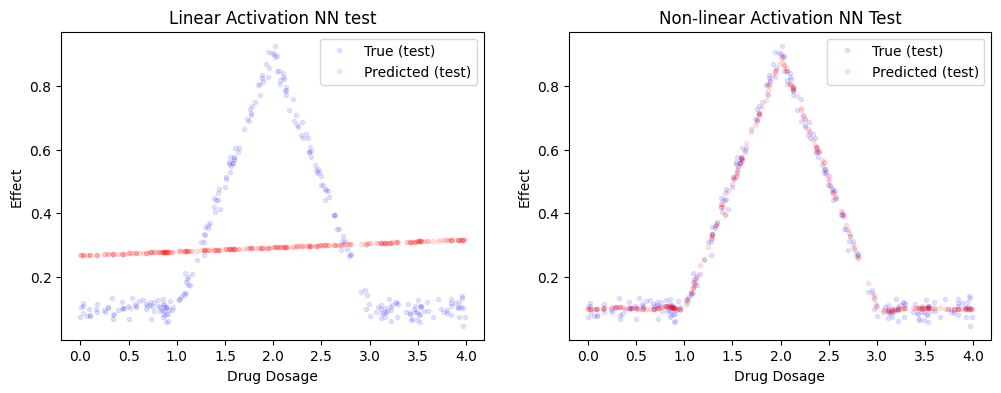

In [ ]:
plt.figure(figsize=(12, 4))

# Plot results
plt.subplot(121)
plt.plot(test_drug_data[:, 0], test_drug_data[:, 1], 'b.', alpha=0.1, label='True (test)')
plt.plot(test_drug_data[:, 0], linear_test_predictions, 'r.', alpha=0.1, label='Predicted (test)')
plt.legend()
plt.title('Linear Activation NN test')
plt.xlabel('Drug Dosage')
plt.ylabel('Effect')

# Plot for Non-linear Model
plt.subplot(122)
plt.plot(test_drug_data[:, 0], test_drug_data[:, 1], 'b.', alpha=0.1, label='True (test)')
plt.plot(test_drug_data[:, 0], nonlinear_test_predictions, 'r.', alpha=0.1, label='Predicted (test)')
plt.legend()
plt.title('Non-linear Activation NN Test')
plt.xlabel('Drug Dosage')
plt.ylabel('Effect')

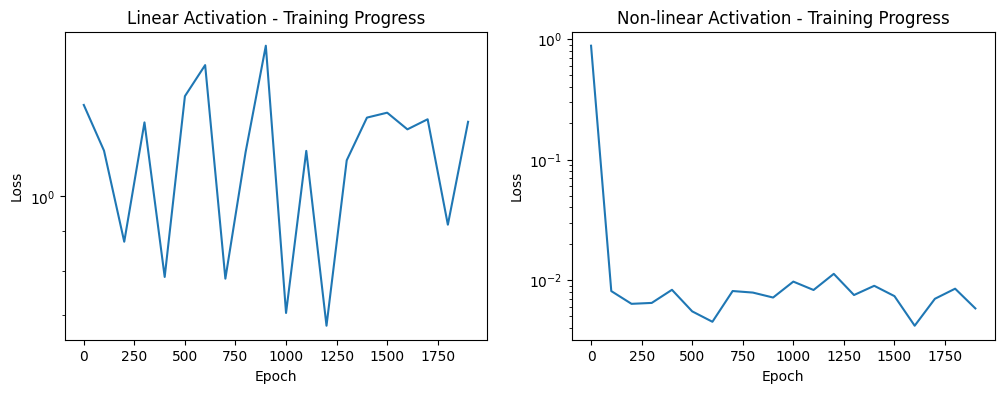

In [ ]:
# Training Progress Comparison
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(range(0, n_epochs, 100), linear_losses)
plt.title('Linear Activation - Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')  # Use log scale for better visualization

plt.subplot(122)
plt.plot(range(0, n_epochs, 100), nonlinear_losses)
plt.title('Non-linear Activation - Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')  # Use log scale for better visualization